## Basic Gaussian distribution with Noise

This section is not very important and can be ignored. The emcee section can be used without having to run any code from here.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
def create_gaussian(mu, sigma, amplitude, size):

    # Create array space
    x = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 1000)

    # Create distribution
    y = amplitude * 2.5 * norm.pdf(x, mu, sigma)

    return y

def noise(mu, sigma, ampltiude, size):

    # Create array space
    x = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 1000)

    # Create distribution
    y = amplitude * np.random.normal(mu, sigma, size)

    return y

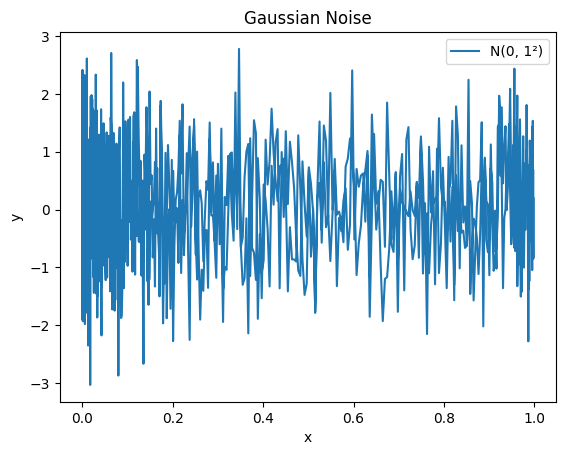

In [3]:
# Create Gaussian

mu = 0
sigma = 1
amplitude = 1
size = 1000

y_gaussian = create_gaussian(mu, sigma, amplitude, size)
y_noise = noise(mu, sigma, amplitude, size)

# Plot the distribution
plt.plot(y_gaussian, y_noise, label=f'N({mu}, {sigma}²)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Gaussian Noise')
plt.legend()
plt.show()

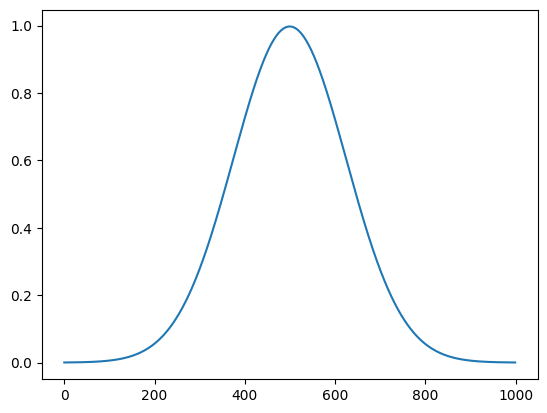

In [4]:
plt.plot(y_gaussian, label=f'N({mu}, {sigma}²)')

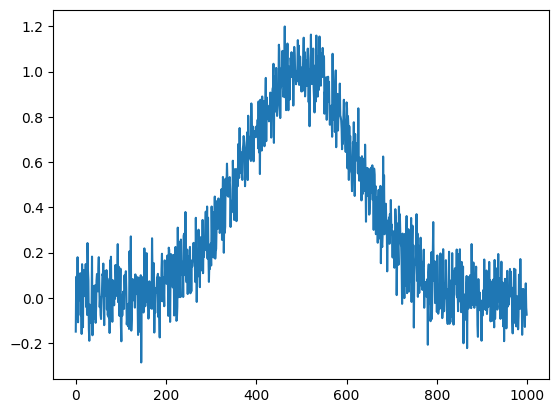

In [5]:
noise_coefficient = 0.1
y = y_gaussian + noise_coefficient * y_noise
plt.plot(y, label=f'N({mu}, {sigma}²)')

## EMCEE Library

We will use this section to test out code from the EMCEE library. Remember you can click on a cell and run all the code below it by pressing on Runtime at the top without having to execute the whole notebook.

In [6]:
import numpy as np
import emcee
import matplotlib.pyplot as plt

Using emcee for MCMC Model Fitting
The emcee package in Python is a powerful Markov Chain Monte Carlo (MCMC) sampler, commonly used for Bayesian inference. Below is a step-by-step guide on how to use emcee to fit a model to data.

Steps for MCMC Model Fitting Using emcee:

- Define a model (e.g., a linear model y=mx+b)

- Define the likelihood function (how probable the data is given model parameters).

- Define the prior distribution (our assumptions before seeing data).

- Define the posterior probability (likelihood × prior).

- Run the MCMC sampler to obtain the posterior distribution of parameters.


### Example: Fitting a Linear Model using MCMC

Let's assume we have noisy data generated from a linear model:

y=mx+b+noise

1. Generate Synthetic Data

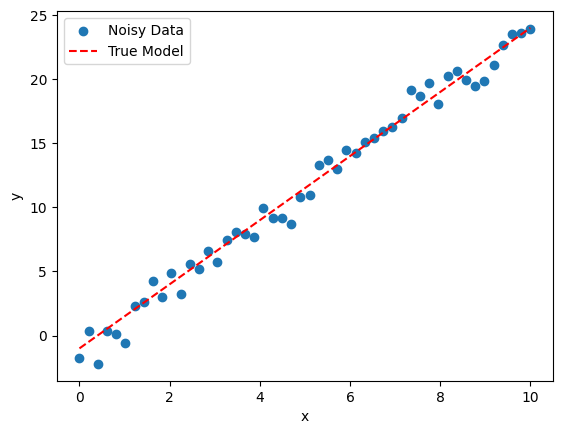

In [7]:
# True parameters
true_m = 2.5
true_b = -1.0
sigma = 0.9  # Noise standard deviation

# Generate x values
x = np.linspace(0, 10, 50)
y = true_m * x + true_b + np.random.normal(0, sigma, size=len(x))

# Plot the data
plt.scatter(x, y, label="Noisy Data")
plt.plot(x, true_m * x + true_b, color="red", label="True Model", linestyle="dashed")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


### Define the Log-Likelihood Function
The likelihood function measures how well the model explains the data. Assuming Gaussian errors:

$
 \log P(y|m, b, \sigma) = -\frac{1}{2} \sum \left( \frac{(y_i - (m x_i + b))^2}{\sigma^2} + \log(2\pi\sigma^2) \right)
$

In [8]:
def log_likelihood_alex(theta, x, y, yerr):
    ''' Log likelihood function for a linear model with Gaussian errors.
    This version acounts for both measurement errors and model-dependent errors.

    Parameters:
    theta : array-like
        Model parameters [m, b, log_f]
    x: array-like
    y: array-like
    yerr: array-like

    --------
    Returns:
        Log likelihood
    
    '''

    m, b, log_f = theta

    # Linear model
    model = m * x + b

    # yerr: is the measurement error
    # np.exp(2 * log_f): term is the model-dependent error, scales with the model's prediction.
    sigma = np.sqrt(yerr**2 + model**2 * np.exp(2 * log_f)) # total error

        # (y - model) / sigma) ** 2          Squared residuals normalized by the total error.
        # np.log(2 * np.pi * sigma ** 2)    Normalization factor for the Gaussian distribution.
    return -0.5 * np.sum(((y - model) / sigma) ** 2 + np.log(2 * np.pi * sigma ** 2))

In [9]:
def log_likelihood(theta, x, y):
    m, b, log_sigma = theta
    sigma = np.exp(log_sigma)  # Ensure sigma is positive
    model = m * x + b
    return -0.5 * np.sum(((y - model) / sigma) ** 2 + np.log(2 * np.pi * sigma ** 2))

### Define the Log-Prior Function
We assume uniform priors for  m and b, and a broad normal prior for log σ:

In [10]:
def log_prior(theta):
    m, b, log_sigma = theta
    if -10 < m < 10 and -10 < b < 10 and -5 < log_sigma < 1:
        return 0.0  # Log of a uniform distribution is constant
    return -np.inf  # Log(0) → reject sample

###  Define the Log-Posterior Function
The posterior is given by:

$
\log P(m, b, \sigma | y) = \log P(y | m, b, \sigma) + \log P(m, b, \sigma)
$

In [11]:
def log_posterior(theta, x, y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf  # Reject invalid samples
    return lp + log_likelihood(theta, x, y)

In [12]:
def log_posterior_alex(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf  # Reject invalid samples
    return lp + log_likelihood_alex(theta, x, y, yerr)

### Run the MCMC Sampler

We initialize multiple walkers (chains) in random positions.

In [13]:
# Number of walkers (parallel chains)
n_walkers = 20
n_dim = 3  # Parameters: m, b, log_sigma
n_steps = 5000  # Number of MCMC steps

# Initial positions: Small random perturbations around reasonable values
initial_positions = np.array([2.0, -1.0, np.log(0.5)]) + 0.1 * np.random.randn(n_walkers, n_dim)

# Set up the MCMC sampler
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior, args=(x, y))
sampler2 = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior_alex, args=(x, y, sigma))

# Run the MCMC sampling
sampler.run_mcmc(initial_positions, n_steps, progress=True)
sampler2.run_mcmc(initial_positions, n_steps, progress=True)

100%|██████████| 5000/5000 [00:01<00:00, 3181.10it/s]


State([[ 2.5751627  -1.56989189 -4.00978859]
 [ 2.52690065 -1.39334917 -4.54646007]
 [ 2.58911822 -1.64364833 -3.54200437]
 [ 2.60432314 -1.474785   -4.88302963]
 [ 2.58209626 -1.54871911 -4.66328815]
 [ 2.52616492 -1.64352621 -3.11893715]
 [ 2.52774853 -1.21762679 -4.4812321 ]
 [ 2.62115272 -1.74383438 -4.68173701]
 [ 2.55373602 -1.18828115 -4.40395429]
 [ 2.48341264 -1.15699806 -4.55594989]
 [ 2.54331298 -1.42140711 -4.24023356]
 [ 2.53845786 -1.52935981 -4.56162756]
 [ 2.59267905 -1.60397931 -4.07282954]
 [ 2.57931071 -1.44391516 -4.35634071]
 [ 2.59748338 -1.38737226 -4.17990167]
 [ 2.54262059 -1.35347395 -4.18322818]
 [ 2.54770729 -1.34610713 -4.52863875]
 [ 2.47030777 -0.93615319 -3.99481516]
 [ 2.53469605 -1.17186569 -3.83122461]
 [ 2.57710304 -1.34981478 -4.67370466]], log_prob=[-65.44352987 -65.75677947 -66.21373584 -66.47862282 -65.18729579
 -70.75928857 -65.28579773 -66.13375652 -66.27812829 -66.73075224
 -65.31909083 -66.44221161 -65.49633068 -65.34982698 -66.91144329
 -65.

### Analyze MCMC Results
Extract and Visualize the Posterior Distributions

In [14]:
# Get MCMC samples (remove burn-in)
samples = sampler.get_chain(discard=500, thin=10, flat=True)
samples2 = sampler2.get_chain(discard=500, thin=10, flat=True)

# Extract parameter estimates (mean & confidence intervals)
m_mcmc, b_mcmc, log_sigma_mcmc = np.percentile(samples, [16, 50, 84], axis=0)
m_mcmc2, b_mcmc2, log_sigma_mcmc2 = np.percentile(samples2, [16, 50, 84], axis=0)

print(f"Estimated m: {m_mcmc}")
print(f"Estimated b: {b_mcmc}")
print(f"Estimated sigma: {np.exp(log_sigma_mcmc)}")  # Convert log_sigma back to sigma

print(f"Estimated m: {m_mcmc2}")
print(f"Estimated b: {b_mcmc2}")
print(f"Estimated sigma: {np.exp(log_sigma_mcmc2)}")  # Convert log_sigma back to sigma

Estimated m: [ 2.51061017 -1.6542811  -0.18675681]
Estimated b: [ 2.55517067 -1.39967937 -0.09017641]
Estimated sigma: [13.45315378  0.31734367  1.01569777]
Estimated m: [ 2.51168525 -1.66447916 -4.76219255]
Estimated b: [ 2.55734462 -1.40981426 -4.27310149]
Estimated sigma: [13.49156654  0.31730585  0.0251692 ]


In [23]:
print( m_mcmc[0]/m_mcmc2[0], b_mcmc[0]/b_mcmc2[0], np.exp(log_sigma_mcmc[0])/np.exp(log_sigma_mcmc2[0]))

0.9995719718263644 0.9991499178158267 0.9971528320972954


Visualizing the MCMC Model Fit

In [15]:
print(f"True m: {true_m}")

True m: 2.5


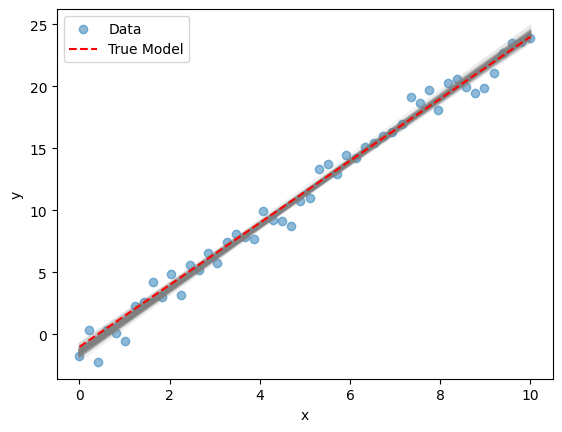

In [16]:
plt.scatter(x, y, label="Data", alpha=0.5)

# Plot 100 random posterior samples
for m, b, log_sigma in samples[np.random.randint(len(samples), size=100)]:
    plt.plot(x, m * x + b, color="gray", alpha=0.1)

# for m, b, log_sigma in samples2[np.random.randint(len(samples2), size=100)]:
#     plt.plot(x, m * x + b, color="blue", alpha=0.1)

# # Estimated model
# plt.plot(x, m_mcmc * x + b_mcmc, color="red", label="Estimated Model")
# plt.plot(x, m_mcmc2 * x + b_mcmc2, color="blue", label="Estimated Model")

# True model
plt.plot(x, true_m * x + true_b, color="red", label="True Model", linestyle="dashed")

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

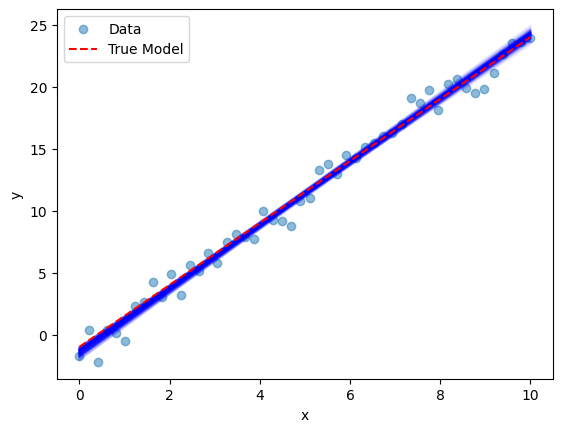

In [17]:
plt.scatter(x, y, label="Data", alpha=0.5)

# # Plot 100 random posterior samples
# for m, b, log_sigma in samples[np.random.randint(len(samples), size=100)]:
#     plt.plot(x, m * x + b, color="gray", alpha=0.1)

for m, b, log_sigma in samples2[np.random.randint(len(samples2), size=100)]:
    plt.plot(x, m * x + b, color="blue", alpha=0.1)

# # Estimated model
# plt.plot(x, m_mcmc * x + b_mcmc, color="red", label="Estimated Model")
# plt.plot(x, m_mcmc2 * x + b_mcmc2, color="blue", label="Estimated Model")

# True model
plt.plot(x, true_m * x + true_b, color="red", label="True Model", linestyle="dashed")

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

In [18]:
# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = true_m * x + true_b
y += np.abs(sigma * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

In [19]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([true_m, true_b, np.log(sigma)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

TypeError: log_likelihood() takes 3 positional arguments but 4 were given

In [ ]:

pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True);

In [ ]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

In [ ]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))